<a href="https://colab.research.google.com/github/justynigam/DS-Task/blob/main/DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

In [7]:
trader_df = pd.read_csv('/content/DStask/historical_data.csv')
sentiment_df = pd.read_csv('/content/DStask/fear_greed_index.csv')

In [16]:
trader_df.columns = trader_df.columns.str.lower().str.replace(' ', '_')

In [17]:
trader_df.head()

,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [20]:
trader_df['timestamp_ist'] = pd.to_datetime(trader_df['timestamp_ist'], format='%d-%m-%Y %H:%M')
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

In [21]:
trader_df['date'] = trader_df['timestamp_ist'].dt.date
trader_df['date'] = pd.to_datetime(trader_df['date'])

In [22]:
merged_df = pd.merge(trader_df, sentiment_df, on='date', how='inner')

In [23]:
if 'leverage' not in merged_df.columns:
    print("Warning: 'leverage' column not found in historical_data.csv. Skipping leverage analysis.")
    leverage_analysis_possible = False
else:
    leverage_analysis_possible = True

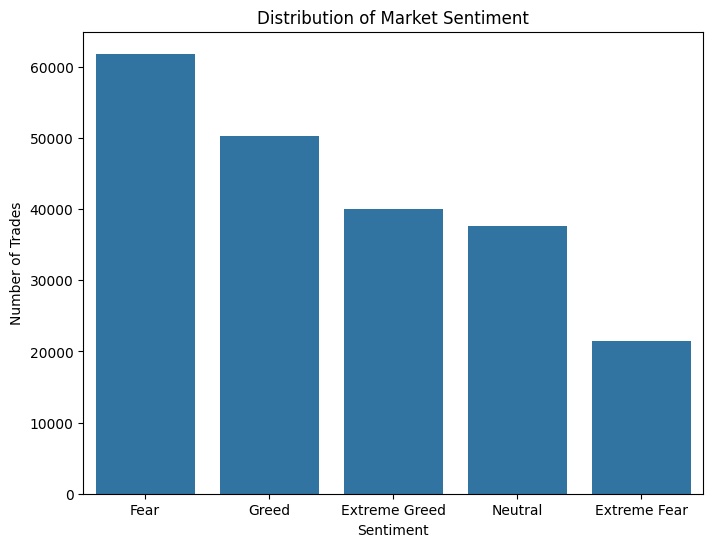

In [24]:
plt.figure(figsize=(8, 6))
sns.countplot(x='classification', data=merged_df, order=merged_df['classification'].value_counts().index)
plt.title('Distribution of Market Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Trades')
plt.savefig('sentiment_distribution.png')
plt.show()

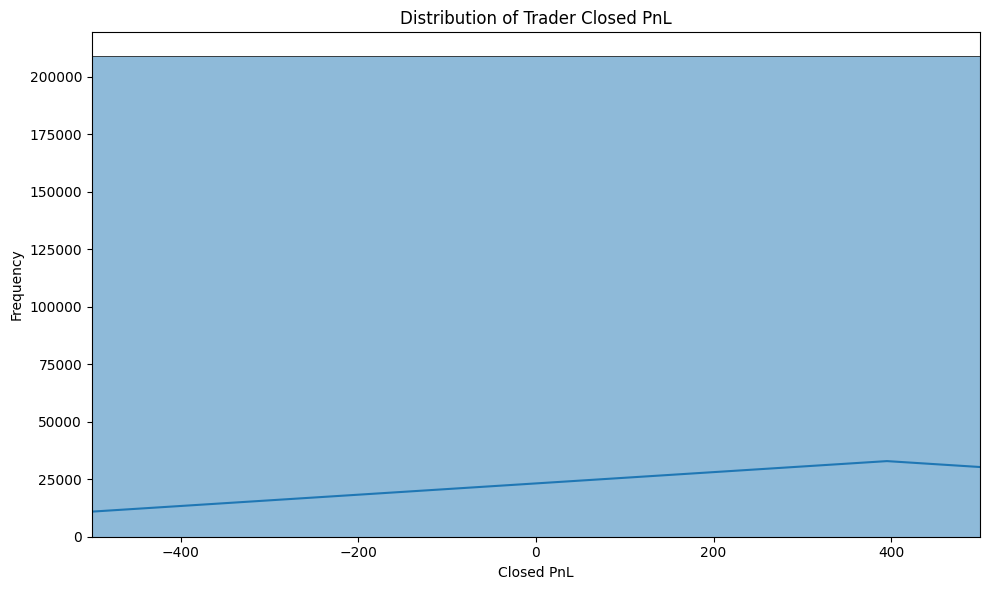

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['closed_pnl'], bins=100, kde=True)
plt.title('Distribution of Trader Closed PnL')
plt.xlabel('Closed PnL')
plt.ylabel('Frequency')
plt.xlim(-500, 500)
plt.tight_layout()
plt.savefig('pnl_distribution.png')
plt.show()

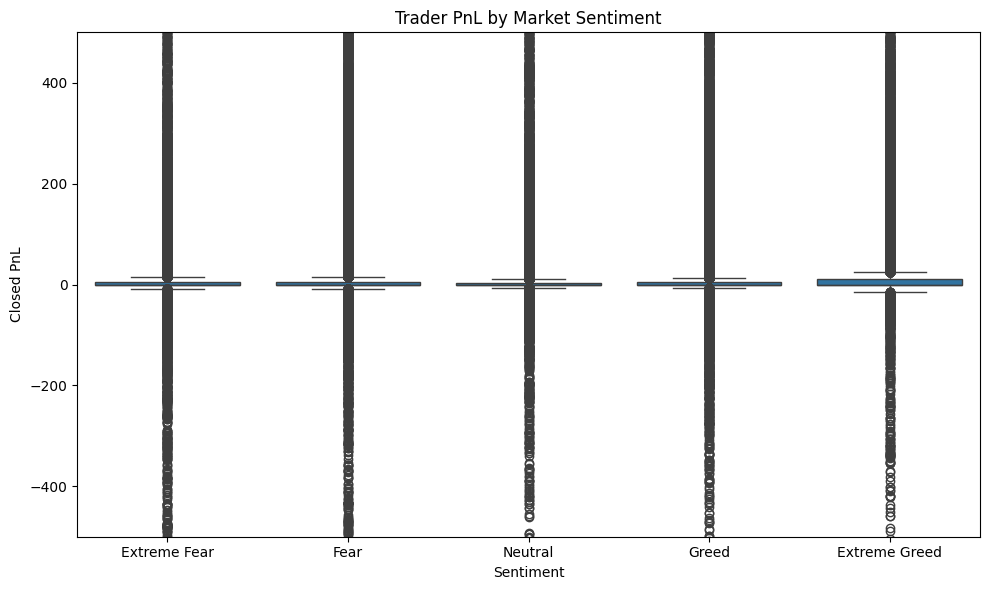

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='classification', y='closed_pnl', data=merged_df, order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Trader PnL by Market Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Closed PnL')
plt.ylim(-500, 500)
plt.tight_layout()
plt.savefig('pnl_by_sentiment.png')
plt.show()

In [28]:
if leverage_analysis_possible:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='classification', y='leverage', data=merged_df, order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
    plt.title('Leverage Used by Market Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Leverage')
    plt.tight_layout()
    plt.savefig('leverage_by_sentiment.png')
    plt.show()

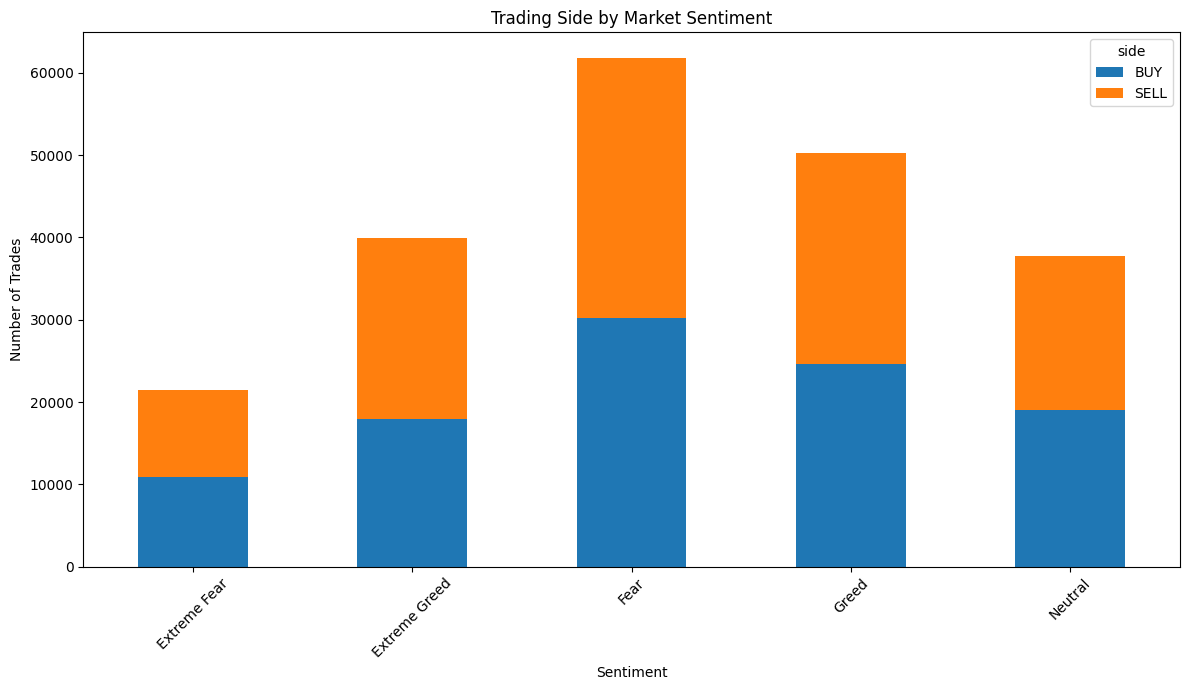

In [29]:
side_sentiment = merged_df.groupby(['classification', 'side']).size().unstack(fill_value=0)
side_sentiment.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Trading Side by Market Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Trades')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('side_by_sentiment.png')
plt.show()

In [31]:
columns_to_check = ['closed_pnl', 'classification', 'side']
if leverage_analysis_possible:
    columns_to_check.append('leverage')


columns_to_check = [col for col in columns_to_check if col in merged_df.columns]

merged_df.dropna(subset=columns_to_check, inplace=True)

In [32]:
merged_df['is_profitable'] = (merged_df['closed_pnl'] > 0).astype(int)

In [35]:
features = ['classification', 'side', 'size_usd']
X = merged_df[features]
y = merged_df['is_profitable']

In [37]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


categorical_features = ['classification', 'side']
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_features]).toarray(),
                         columns=encoder.get_feature_names_out(categorical_features))

X = pd.concat([X.drop(columns=categorical_features).reset_index(drop=True), X_encoded], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

In [42]:
from sklearn.metrics import accuracy_score, classification_report

print("--- Predictive Model Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Profitable', 'Profitable']))

--- Predictive Model Results ---
Accuracy: 0.63

Classification Report:
                precision    recall  f1-score   support

Not Profitable       0.73      0.60      0.66     24871
    Profitable       0.54      0.67      0.60     17373

      accuracy                           0.63     42244
     macro avg       0.63      0.64      0.63     42244
  weighted avg       0.65      0.63      0.63     42244




Confusion Matrix:


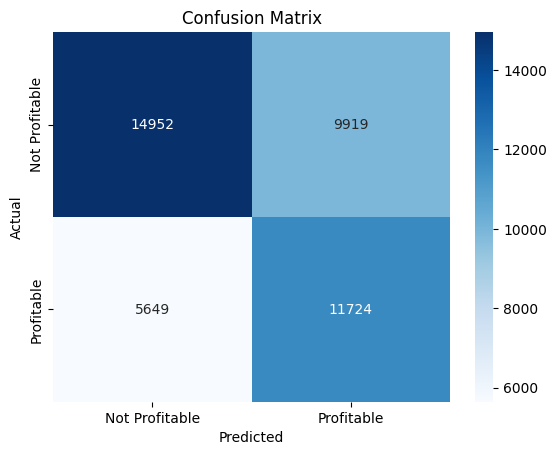

In [46]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Profitable', 'Profitable'], yticklabels=['Not Profitable', 'Profitable'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()